# Análisis Exploratorio de Datos (EDA)
## Proyecto Final: Predicción de Condiciones para Vuelo a Vela

**Objetivo:** Entender los datos de vuelos y meteorología antes de modelar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Para mostrar todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Carga de Datos

In [2]:
# Cargar dataset de desarrollo
df = pd.read_csv('data/processed/vuelos_dev.csv')

print(f"Shape del dataset: {df.shape}")
print(f"\nPrimeras filas:")
df.head()

Shape del dataset: (309, 30)

Primeras filas:


,flight_id,fecha,pilot,glider,mes,dia_año,solar_rad_total,solar_rad_max,precipitation_total,temp_2m_max,temp_2m_min,temp_2m_mean,cloud_cover_mean,wind_u_mean,wind_v_mean,pressure_mean,boundary_layer_height_mean,boundary_layer_height_max,cape_mean,cape_max,skin_temp_max,skin_temp_min,skin_temp_mean,temp_differential,wind_speed_mean,altura_max_m,ganancia_altura_m,duracion_min,distancia_km,calidad_dia
0,IGC_0301,2024-01-13,RAUL BREGY,Std Cirrus,1,13,7.196953e+06,1089.528889,943.775177,34.610986,12.850244,24.240350,0.328554,0.182556,-4.181376,1001.525781,857.985413,3096.654297,230.085983,1915.125,41.040918,12.784814,26.771417,21.760742,4.185360,1387,1285,137.3,243.8,Regular
1,IGC_0103,2024-10-19,Miguel Angel Serrano,401 Kestrel 19m,10,293,7.348072e+06,1027.840000,36.174774,32.574854,8.780176,22.129999,0.236418,-1.141683,-3.855716,1003.483203,716.453613,1826.395020,16.646801,1318.375,36.486475,9.063379,24.078851,23.794678,4.021192,1516,1418,127.6,216.5,Bueno
2,IGC_0109,2024-12-16,carlos martin lorenzo,PW-5 Smyk,12,351,8.371297e+06,1118.435556,18.896580,34.825830,7.974268,21.724481,0.199916,-2.061696,0.720547,1007.207109,857.369446,2782.011475,0.660326,42.375,46.454980,8.578027,26.472101,26.851562,2.183983,1878,1685,161.9,281.3,Bueno
3,IGC_0052,2024-12-14,Andres Totorica,SZD-48-2 Ja,12,349,7.969279e+06,1115.342222,121.024609,35.353662,11.701807,23.307611,0.269733,-0.667587,3.302644,1002.110312,913.127991,2902.341309,166.153183,1920.125,46.063135,11.782373,26.796289,23.651855,3.369440,2542,2345,184.5,356.4,Excelente
4,IGC_0051,2025-04-19,Federico Scalise Giussani,Unknown,4,109,4.192632e+06,767.715556,135.335922,25.381738,2.943506,14.442194,0.379930,0.412382,3.473554,1012.356250,704.885681,1621.703369,2.112222,44.000,30.433740,1.822900,16.697198,22.438232,3.497947,1297,1271,84.0,119.8,Regular


In [3]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   flight_id                   309 non-null    object 
 1   fecha                       309 non-null    object 
 2   pilot                       309 non-null    object 
 3   glider                      309 non-null    object 
 4   mes                         309 non-null    int64  
 5   dia_año                     309 non-null    int64  
 6   solar_rad_total             309 non-null    float64
 7   solar_rad_max               309 non-null    float64
 8   precipitation_total         309 non-null    float64
 9   temp_2m_max                 309 non-null    float64
 10  temp_2m_min                 309 non-null    float64
 11  temp_2m_mean                309 non-null    float64
 12  cloud_cover_mean            309 non-null    float64
 13  wind_u_mean                 309 non

## 2. Variables Target

Analizamos las variables que queremos predecir

In [4]:
# Variables target
targets = ['altura_max_m', 'ganancia_altura_m', 'duracion_min', 'distancia_km', 'calidad_dia']

print("Estadísticos descriptivos de targets:")
df[targets[:-1]].describe()

Estadísticos descriptivos de targets:


,altura_max_m,ganancia_altura_m,duracion_min,distancia_km
count,309.000000,309.000000,309.000000,309.000000
mean,2224.546926,2084.530744,197.488673,393.538511
std,3605.937514,3598.977648,72.148067,169.195472
min,562.000000,532.000000,13.200000,12.100000
25%,1704.000000,1543.000000,156.100000,284.400000
50%,1993.000000,1849.000000,204.400000,398.400000
75%,2292.000000,2132.000000,240.800000,509.100000
max,64500.000000,64299.000000,370.300000,864.600000


In [5]:
# Distribución de calidad_dia
print("Distribución de calidad del día:")
print(df['calidad_dia'].value_counts().sort_index())
print(f"\nPorcentajes:")
print(df['calidad_dia'].value_counts(normalize=True).sort_index() * 100)

Distribución de calidad del día:
calidad_dia
Bueno        198
Excelente     55
Malo           8
Regular       48
Name: count, dtype: int64

Porcentajes:
calidad_dia
Bueno        64.077670
Excelente    17.799353
Malo          2.588997
Regular      15.533981
Name: proportion, dtype: float64


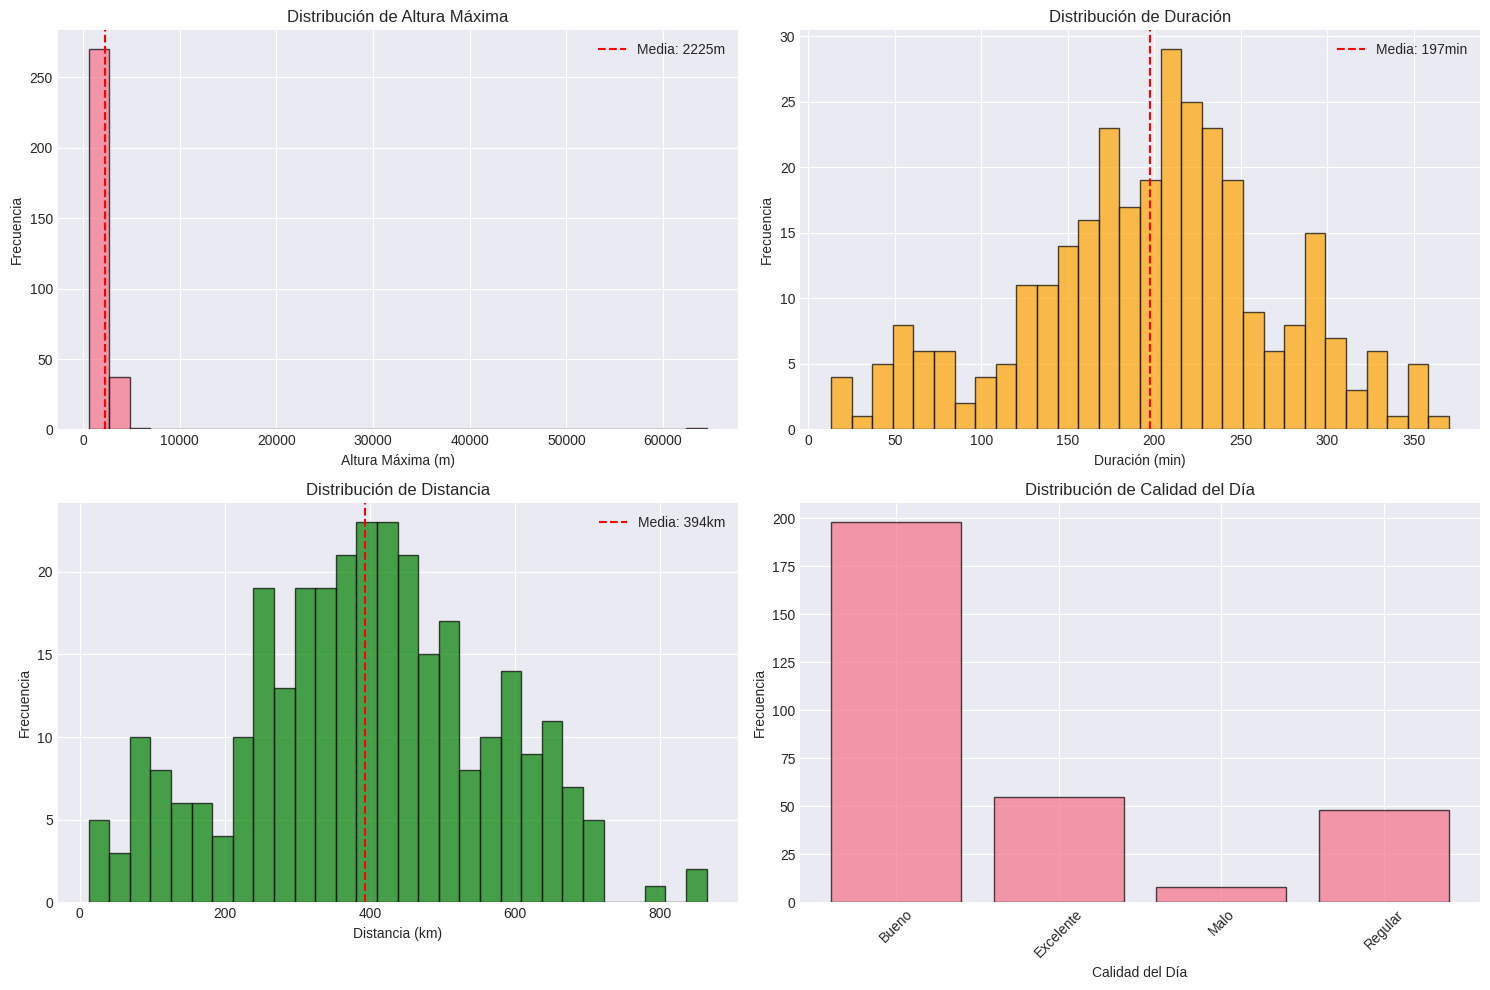

In [6]:
# Visualización de targets
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Altura máxima
axes[0, 0].hist(df['altura_max_m'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Altura Máxima (m)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Altura Máxima')
axes[0, 0].axvline(df['altura_max_m'].mean(), color='red', linestyle='--', label=f'Media: {df["altura_max_m"].mean():.0f}m')
axes[0, 0].legend()

# Duración
axes[0, 1].hist(df['duracion_min'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Duración (min)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Duración')
axes[0, 1].axvline(df['duracion_min'].mean(), color='red', linestyle='--', label=f'Media: {df["duracion_min"].mean():.0f}min')
axes[0, 1].legend()

# Distancia
axes[1, 0].hist(df['distancia_km'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Distancia (km)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Distancia')
axes[1, 0].axvline(df['distancia_km'].mean(), color='red', linestyle='--', label=f'Media: {df["distancia_km"].mean():.0f}km')
axes[1, 0].legend()

# Calidad del día
calidad_counts = df['calidad_dia'].value_counts().sort_index()
axes[1, 1].bar(calidad_counts.index, calidad_counts.values, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Calidad del Día')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Calidad del Día')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Variables Meteorológicas

Exploramos las features que usaremos para predecir

In [7]:
# Identificar features meteorológicas
features_meteo = [col for col in df.columns if col not in targets + 
                  ['flight_id', 'fecha', 'pilot', 'glider', 'mes', 'dia_año', 'fecha_dt']]

print(f"Features meteorológicas disponibles: {len(features_meteo)}")
print("\nLista de features:")
for i, feat in enumerate(features_meteo, 1):
    print(f"{i:2d}. {feat}")

Features meteorológicas disponibles: 19

Lista de features:
 1. solar_rad_total
 2. solar_rad_max
 3. precipitation_total
 4. temp_2m_max
 5. temp_2m_min
 6. temp_2m_mean
 7. cloud_cover_mean
 8. wind_u_mean
 9. wind_v_mean
10. pressure_mean
11. boundary_layer_height_mean
12. boundary_layer_height_max
13. cape_mean
14. cape_max
15. skin_temp_max
16. skin_temp_min
17. skin_temp_mean
18. temp_differential
19. wind_speed_mean


In [8]:
# Estadísticos de features meteorológicas
print("Estadísticos de features meteorológicas:")
df[features_meteo].describe().T

Estadísticos de features meteorológicas:


,count,mean,std,min,25%,50%,75%,max
solar_rad_total,309.0,7.285750e+06,1.113001e+06,2.728936e+06,7.109353e+06,7.595185e+06,8.004866e+06,8.503747e+06
solar_rad_max,309.0,1.054797e+03,9.586139e+01,5.994133e+02,1.052196e+03,1.092587e+03,1.100480e+03,1.136178e+03
precipitation_total,309.0,2.847314e+02,9.914373e+02,0.000000e+00,9.570599e+00,4.971743e+01,1.702495e+02,1.072013e+04
temp_2m_max,309.0,3.523579e+01,5.235215e+00,1.504507e+01,3.329189e+01,3.678530e+01,3.868472e+01,4.404873e+01
temp_2m_min,309.0,1.092489e+01,4.930869e+00,-5.125586e+00,8.895166e+00,1.149111e+01,1.407729e+01,1.928481e+01
temp_2m_mean,309.0,2.291902e+01,4.486286e+00,6.554468e+00,2.172448e+01,2.404724e+01,2.550482e+01,2.887539e+01
cloud_cover_mean,309.0,2.800357e-01,1.542787e-01,2.397033e-03,1.666488e-01,2.743663e-01,3.961235e-01,7.804954e-01
wind_u_mean,309.0,-1.085349e+00,1.385946e+00,-4.778674e+00,-2.061696e+00,-1.335686e+00,-2.843910e-01,4.627687e+00
wind_v_mean,309.0,-9.000210e-01,2.178425e+00,-4.868322e+00,-2.523424e+00,-1.557162e+00,5.754387e-01,4.893496e+00
pressure_mean,309.0,1.004562e+03,4.466683e+00,9.956437e+02,1.002110e+03,1.004200e+03,1.005799e+03,1.020805e+03


In [9]:
# Verificar valores faltantes
print("Valores faltantes por columna:")
missing = df[features_meteo].isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print(missing)
else:
    print("No hay valores faltantes en features meteorológicas ✓")

Valores faltantes por columna:
No hay valores faltantes en features meteorológicas ✓


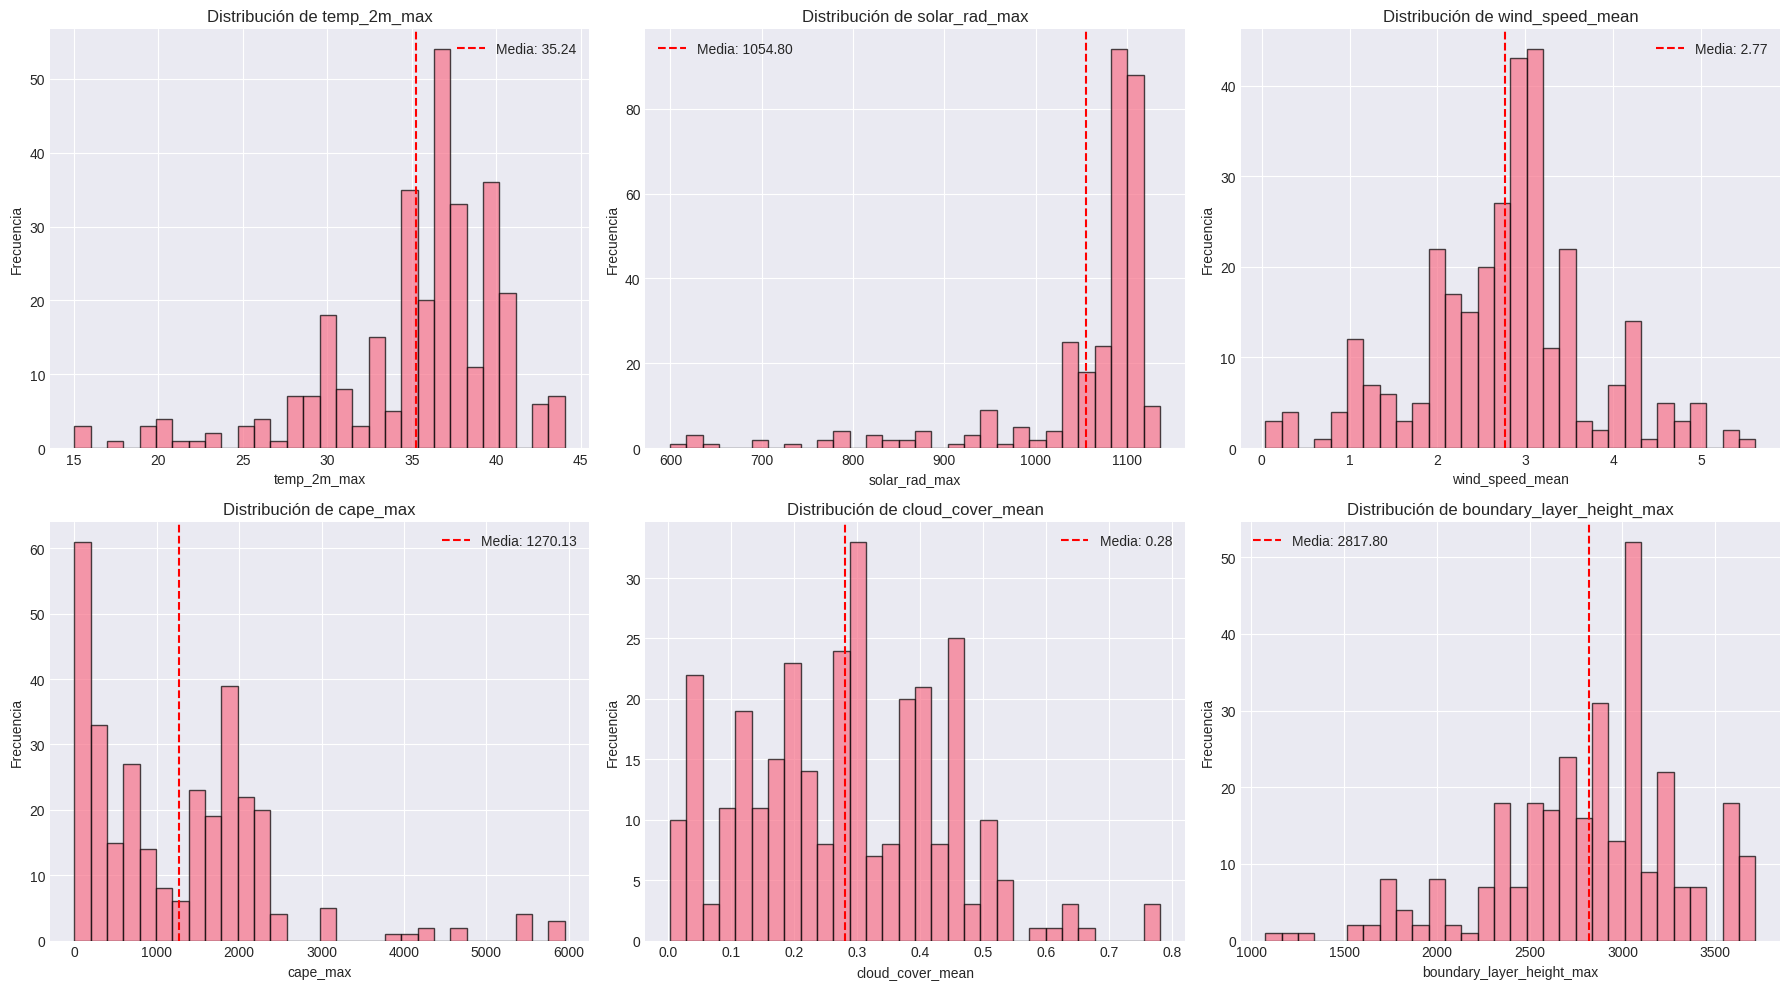

In [10]:
# Visualizar distribuciones de features clave
features_clave = [
    'temp_2m_max',
    'solar_rad_max',
    'wind_speed_mean',
    'cape_max',
    'cloud_cover_mean',
    'boundary_layer_height_max'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feat in enumerate(features_clave):
    axes[i].hist(df[feat], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de {feat}')
    axes[i].axvline(df[feat].mean(), color='red', linestyle='--', label=f'Media: {df[feat].mean():.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

## 4. Correlaciones

Analizar correlaciones entre features y targets

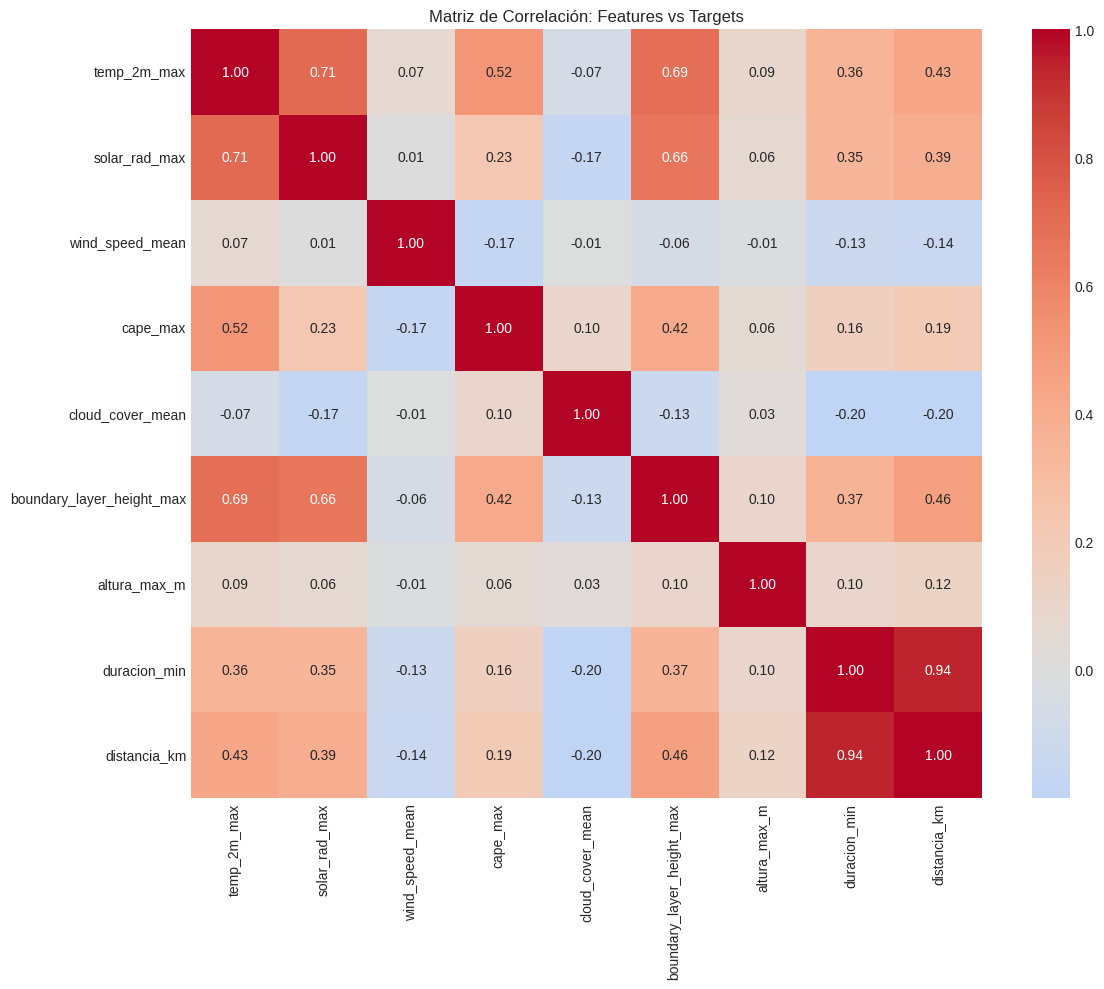

In [11]:
# Matriz de correlación con targets numéricos
targets_numericos = ['altura_max_m', 'duracion_min', 'distancia_km']
correlaciones = df[features_clave + targets_numericos].corr()

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(correlaciones, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matriz de Correlación: Features vs Targets')
plt.tight_layout()
plt.show()

In [12]:
# Correlaciones específicas con altura_max_m
corr_altura = df[features_meteo + ['altura_max_m']].corr()['altura_max_m'].sort_values(ascending=False)

print("Top 10 features más correlacionadas con altura_max_m:")
print(corr_altura.head(11)[1:])  # Excluir la auto-correlación

print("\nTop 10 features menos correlacionadas (negativas):")
print(corr_altura.tail(10))

Top 10 features más correlacionadas con altura_max_m:
boundary_layer_height_max    0.103531
skin_temp_max                0.100923
temp_differential            0.090873
temp_2m_max                  0.089403
skin_temp_mean               0.088239
temp_2m_mean                 0.074861
solar_rad_total              0.066036
solar_rad_max                0.063994
cape_max                     0.057583
skin_temp_min                0.053004
Name: altura_max_m, dtype: float64

Top 10 features menos correlacionadas (negativas):
skin_temp_min                 0.053004
temp_2m_min                   0.044897
cloud_cover_mean              0.029867
boundary_layer_height_mean    0.015208
wind_speed_mean              -0.009920
cape_mean                    -0.016101
wind_v_mean                  -0.020537
precipitation_total          -0.029978
wind_u_mean                  -0.051969
pressure_mean                -0.062407
Name: altura_max_m, dtype: float64


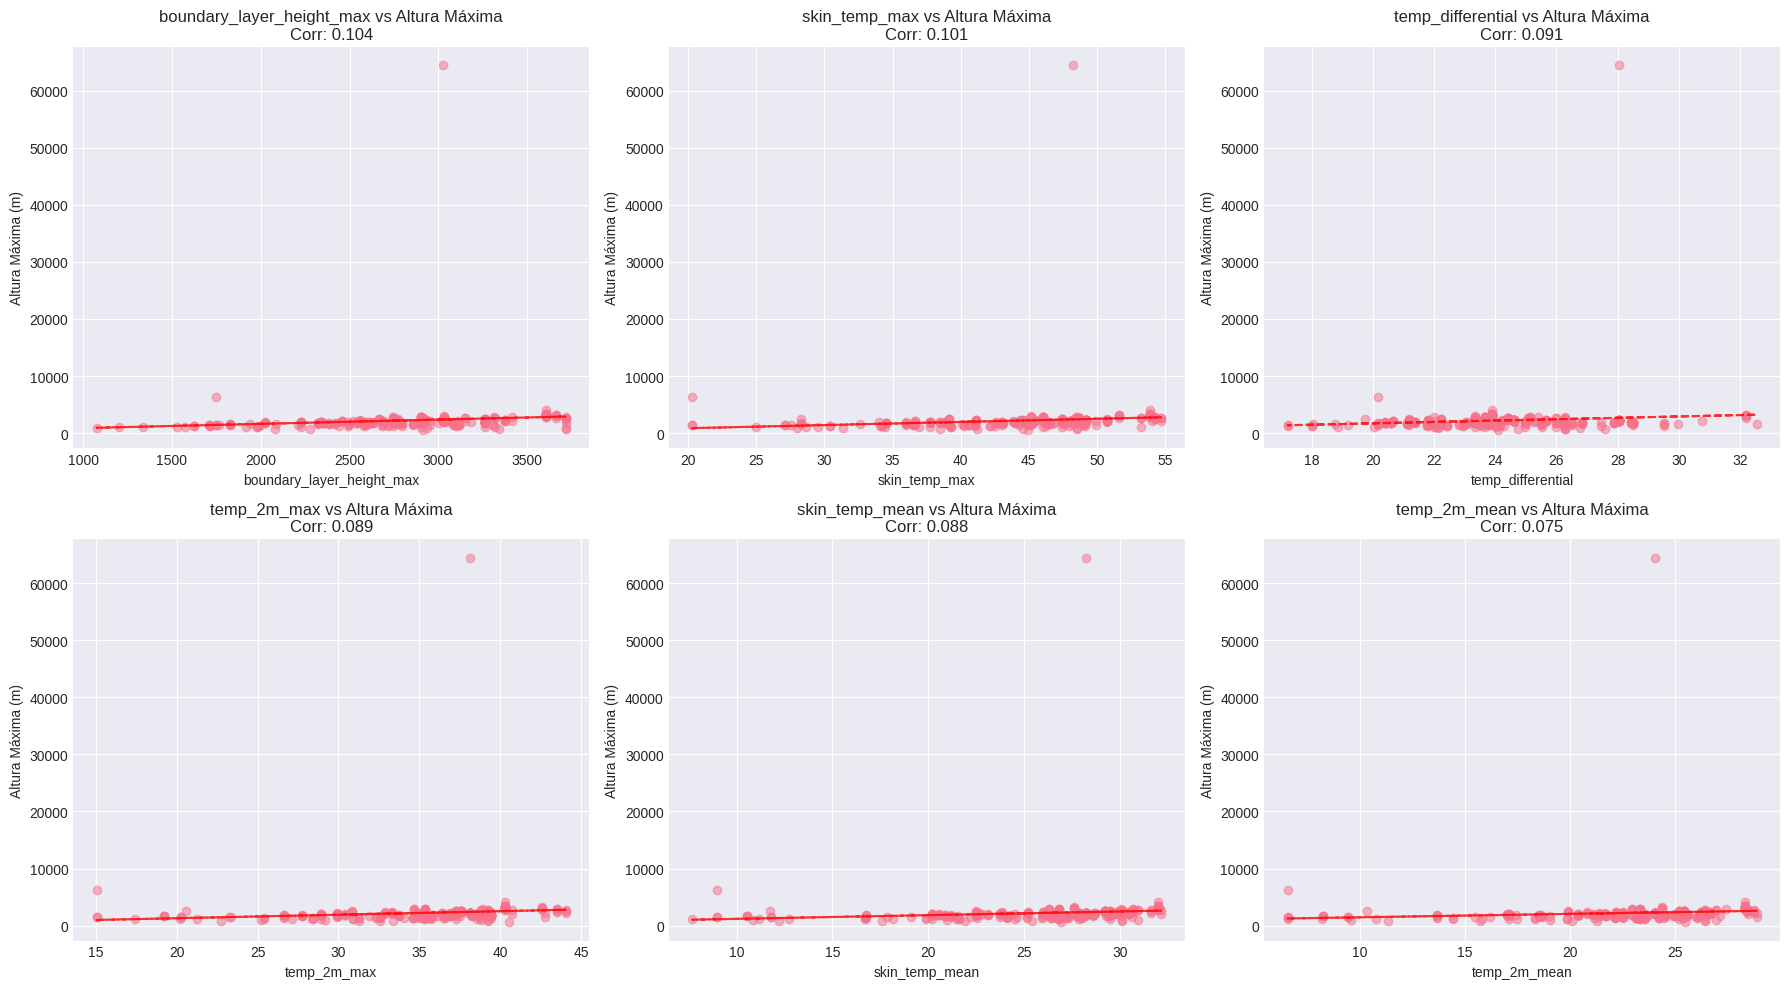

In [13]:
# Visualizar correlaciones más fuertes
top_features = corr_altura.head(7)[1:].index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feat in enumerate(top_features[:6]):
    axes[i].scatter(df[feat], df['altura_max_m'], alpha=0.5)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('Altura Máxima (m)')
    axes[i].set_title(f'{feat} vs Altura Máxima\nCorr: {corr_altura[feat]:.3f}')
    
    # Línea de tendencia
    z = np.polyfit(df[feat], df['altura_max_m'], 1)
    p = np.poly1d(z)
    axes[i].plot(df[feat], p(df[feat]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

## 5. Análisis por Calidad del Día

Comparar features según la calidad del día

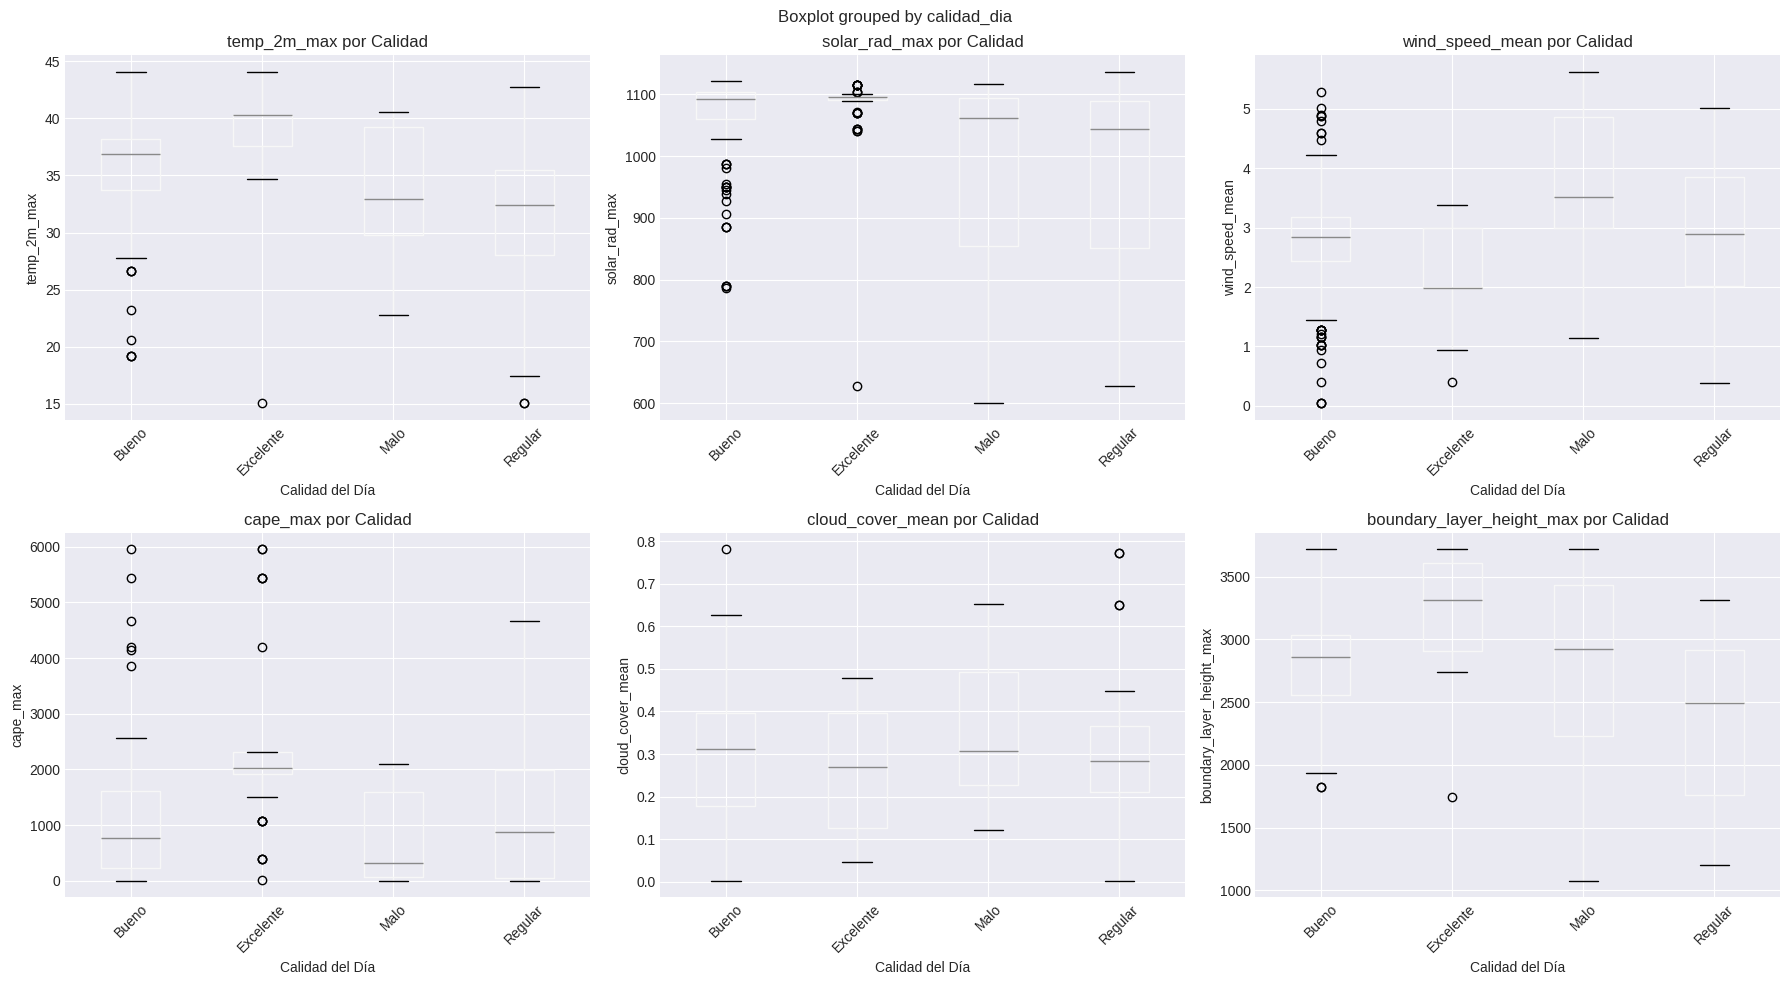

In [14]:
# Boxplots de features clave por calidad
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feat in enumerate(features_clave):
    df.boxplot(column=feat, by='calidad_dia', ax=axes[i])
    axes[i].set_xlabel('Calidad del Día')
    axes[i].set_ylabel(feat)
    axes[i].set_title(f'{feat} por Calidad')
    plt.sca(axes[i])
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 6. Detección de Outliers

In [15]:
# Método IQR para detección de outliers en targets
def detectar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[columna] < lower_bound) | (df[columna] > upper_bound)]
    
    return outliers, lower_bound, upper_bound

print("Análisis de outliers en targets:\n")
for target in targets_numericos:
    outliers, lb, ub = detectar_outliers_iqr(df, target)
    print(f"{target}:")
    print(f"  Outliers detectados: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
    print(f"  Rango normal: [{lb:.1f}, {ub:.1f}]")
    print()

Análisis de outliers en targets:

altura_max_m:
  Outliers detectados: 17 (5.5%)
  Rango normal: [822.0, 3174.0]

duracion_min:
  Outliers detectados: 5 (1.6%)
  Rango normal: [29.0, 367.9]

distancia_km:
  Outliers detectados: 2 (0.6%)
  Rango normal: [-52.7, 846.2]



## 7. Análisis Temporal

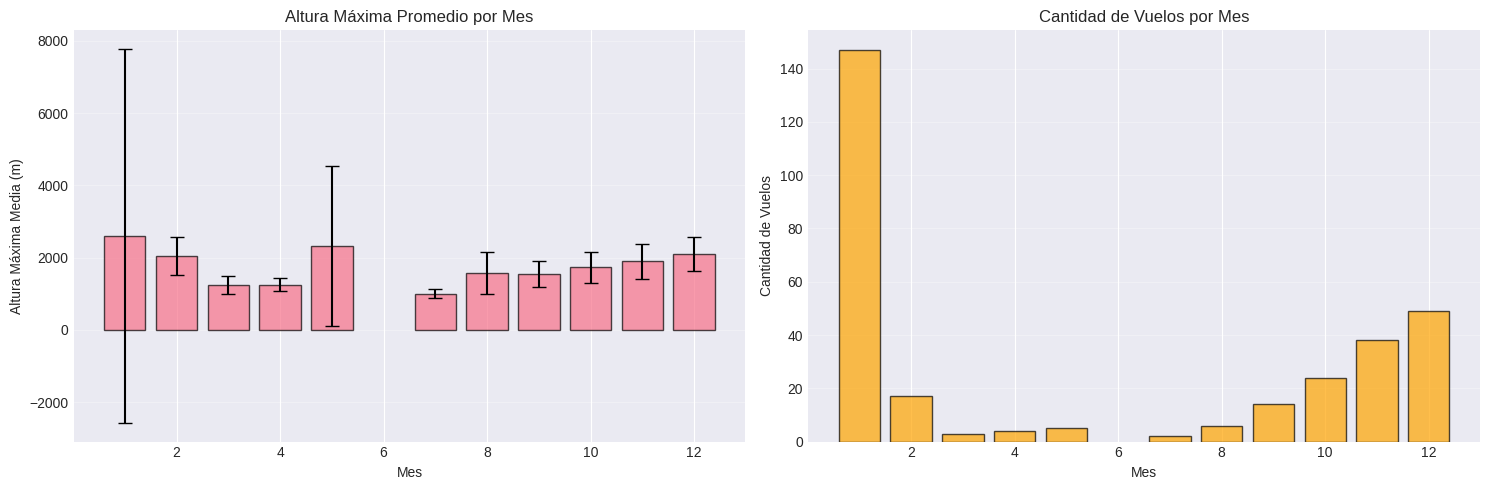

In [16]:
# Convertir fecha a datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Altura promedio por mes
altura_por_mes = df.groupby('mes')['altura_max_m'].agg(['mean', 'std', 'count'])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Altura promedio por mes
axes[0].bar(altura_por_mes.index, altura_por_mes['mean'], yerr=altura_por_mes['std'], 
            capsize=5, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Mes')
axes[0].set_ylabel('Altura Máxima Media (m)')
axes[0].set_title('Altura Máxima Promedio por Mes')
axes[0].grid(axis='y', alpha=0.3)

# Cantidad de vuelos por mes
axes[1].bar(altura_por_mes.index, altura_por_mes['count'], alpha=0.7, 
            edgecolor='black', color='orange')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Cantidad de Vuelos')
axes[1].set_title('Cantidad de Vuelos por Mes')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Conclusiones del EDA

**Escribe aquí tus observaciones:**

1. Distribución de targets:
   - ...

2. Features más importantes:
   - ...

3. Outliers detectados:
   - ...

4. Patrones temporales:
   - ...

5. Próximos pasos:
   - Preprocesamiento necesario
   - Feature engineering
   - Selección de features

## 9. Guardar Insights

Guardar información relevante para el modelado

In [18]:
# Guardar lista de features importantes
top_features_lista = corr_altura.head(11)[1:].index.tolist()

import json

insights = {
    'features_meteo': features_meteo,
    'top_features_correlacion': top_features_lista,
    'targets_numericos': targets_numericos,
    'estadisticos_targets': df[targets_numericos].describe().to_dict()
}

with open('data/processed/eda_insights.json', 'w') as f:
    json.dump(insights, f, indent=2)

print("✓ Insights guardados en: data/processed/eda_insights.json")

✓ Insights guardados en: data/processed/eda_insights.json
